# Preparing the data

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading the data
# https://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval)
df = pd.read_csv("Credit_Card_Applications.csv")
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [2]:
# Split the data
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values # Class if credit application is approved or not

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range = (0, 1))
X = mms.fit_transform(X)

# Self Organizing Map model

## Training the model

In [3]:
from minisom import MiniSom
# Initiliaze the SOM model
som = MiniSom(x = 10, y = 10, input_len = X.shape[1],
             sigma = 1.0, learning_rate = 0.5,
             random_seed = 123) # (x, y) = SOM output grid dimension
# Initiliaze random weights for the model
som.random_weights_init(data = X)
# Train the SOM model
som.train_random(data = X, num_iteration = 500)

## Visualising the results
Depending on the winning node with a high Mean Interneuron Distance (MID), we will identify potential fraud cases. After visualising the SOM below, the outliers with white color and high MID and also got the approval of the bank represent the potential fraud cases.

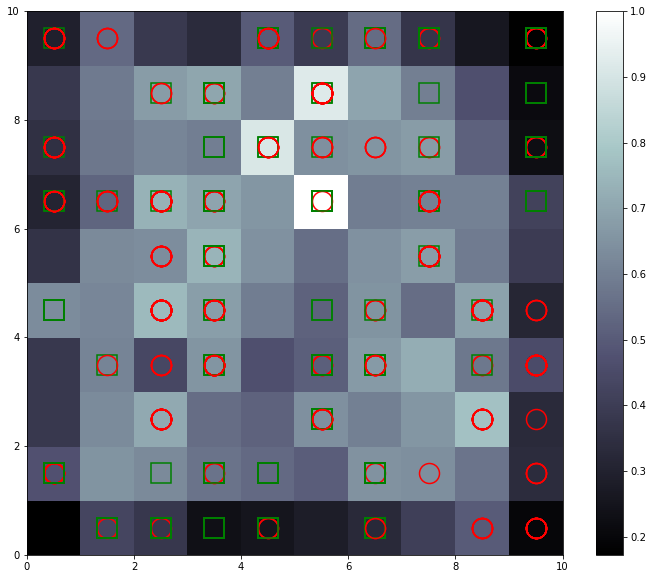

In [4]:
plt.figure(figsize = (12, 10))
plt.bone() # Initiate the frame
plt.pcolor(som.distance_map().T) # Color the distance matrix
plt.colorbar() # Legend for colors
markers = ['o', 's'] # o : circle, s: square
colors = ['r', 'g'] # Red = rejected, Green = approved
for i, x in enumerate(X):
    w = som.winner(x) # Take the customer's winning node coordinates
    plt.plot(w[0] + 0.5, # + 0.5 for centrering the marker
             w[1] + 0.5,
             markers[y[i]],
             markeredgecolor = colors[y[i]],
             markerfacecolor = 'None',
             markeredgewidth = 1.5,
             markersize = 20)
plt.show()

## Finding the potential frauds
According the mapping above, the outliers with high MIDs at (5, 6), (4, 7) and (5, 8) coordinates include potential fraud cases.

In [5]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(5, 6)], mappings[(4, 7)], mappings[(5, 8)]))
frauds = mms.inverse_transform(frauds)
results = pd.DataFrame([int(i) for i in frauds[:, 0]], 
                      columns = ['Fraud Customer ID'])
results.style

,Fraud Customer ID
0,15597536
1,15571284
2,15570947
3,15641715
4,15589881
5,15592326
6,15580579
7,15665374
8,15731586
9,15575605


# Building Artificial Neural Network

In [6]:
# Creating the matrix of features
customers = df.iloc[:, 1:].values

# Creating the dependent variable
is_fraud = np.zeros(df.shape[0], dtype = np.int64)
for i in range(df.shape[0]):
    if df.iloc[i, 0] in frauds:
        is_fraud[i] = 1


In [7]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

In [8]:
import tensorflow as tf
import tensorflow.keras.layers as F

def build_ann():
    model = tf.keras.models.Sequential()
    model.add(F.Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = customers.shape[1]))
    model.add(F.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [9]:
# Training the ANN model 
ann = build_ann()
ann.fit(customers, is_fraud, batch_size = 1, epochs = 3)

Epoch 1/3
690/690 [==============================] - 1s 715us/step - loss: 0.5062 - accuracy: 0.9304
Epoch 2/3
690/690 [==============================] - 0s 714us/step - loss: 0.2475 - accuracy: 0.9377
Epoch 3/3
690/690 [==============================] - 0s 718us/step - loss: 0.2064 - accuracy: 0.9377


In [10]:
# Get the predictions and rank their probabilities
y_pred = ann.predict(customers)
y_pred = np.concatenate((df.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()[::-1]]

In [11]:
probs_per_customer = pd.DataFrame(y_pred, columns = ['CustomerID', 'Fraud Probability'])
probs_per_customer['CustomerID'] = probs_per_customer['CustomerID'].astype(np.int64)
probs_per_customer.head(10).style

,CustomerID,Fraud Probability
0,15699238,0.321697
1,15636626,0.309194
2,15600027,0.301901
3,15609070,0.282320
4,15744044,0.279483
5,15575605,0.269781
6,15700549,0.268856
7,15599272,0.259603
8,15726167,0.256724
9,15649101,0.251475
